## Plot physical variables and their EOF spatial patterns to better understand the features

In [8]:
%matplotlib inline
from netCDF4 import Dataset as ncread
import netCDF4 as nc
import numpy as np
from scipy.io import loadmat
import pandas as pd
import h5py
import math
import pandas as pd
from datetime import datetime
from itertools import product
from cftime import DatetimeNoLeap
import xarray as xr
from eofs.standard import Eof

In [9]:
import matplotlib.pyplot as plt
from matplotlib import rcParams #For changing text properties
import cmocean #A package with beautiful colormaps
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.path as mpath

In [10]:
from datetime import datetime 
from datetime import timedelta
from datetime import date
import time

In [11]:
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.utils import shuffle

### Mask

Frozen(SortedKeysDict({'latitude': 28, 'longitude': 31}))

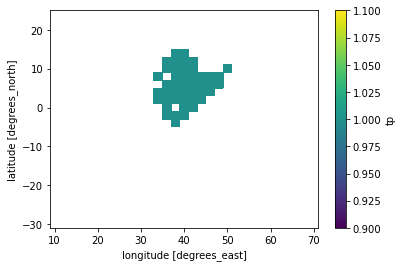

In [29]:
# Import regional mask
root_data = '/s2s/mpyrina/Lorentz_Workshop/Data/'
root_results = '/s2s_nobackup/zhengwu/workshop/'

file = 'era5_hoa_dry_mask_2deg.nc' #0.25

mask=xr.open_mfdataset(root_data+file,combine='by_coords',parallel=True)
mask_nan=mask.where(mask==1) #keep the values==1 and mask the rest
mask_nan.tp.plot()
mask_nan.sizes

### Precipitation

/net/cfc/s2s/s2s_ai_challenge/conda/envs/s2sai_2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/net/cfc/s2s/s2s_ai_challenge/conda/envs/s2sai_2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


Text(0.5, 1.03, 'precip')

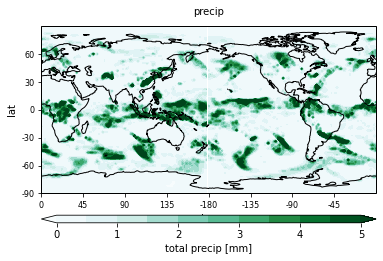

In [31]:
# Calculate the spatial mean of the tp file after applying the spatial mask
root_data = '/s2s/mpyrina/Lorentz_Workshop/Data/'
root_results = '/s2s_nobackup/zhengwu/workshop/'

file=xr.open_mfdataset(root_data+f'/era5_tp_1959-2021_1_12_daily_2.0deg.nc',
                          combine='by_coords',parallel=True)
lon = file.coords['longitude'].values
lat = file.coords['latitude'].values

# plot the original data 
color = 'BuGn' 
colorbarMin = 0
colorbarMax = 5
colorspace = 0.5
level = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)
ax = plt.axes(projection=ccrs.cartopy.crs.PlateCarree(central_longitude=180))
h = ax.contourf(lon, lat, file['tp'][122,:,:]*1000, level, transform=ccrs.PlateCarree(), cmap=color,extend='both')
cbar = plt.colorbar(h, orientation='horizontal', shrink=1,fraction=0.1,pad=0.1,aspect=40)
cbar.ax.tick_params(labelsize=10) 
colorLabel='total precip [mm]'
cbar.set_label(label=colorLabel,fontsize=10)
#Add in the coordinate system:
long = np.arange(-180, 180, 45)
latg = np.arange(-90, 90, 30)
ax.set_xticks(long, crs=ccrs.PlateCarree());
ax.set_yticks(latg, crs=ccrs.PlateCarree());
ax.set_xticklabels(long,fontsize=8)
ax.set_yticklabels(latg,fontsize=8)
ax.set_ylabel('lat',fontsize=10);
ax.set_xlabel('lon',fontsize=10);

#Add in the continents
#define the coastlines, the color (#000000) and the resolution (110m) 
feature1 = cf.NaturalEarthFeature(
    name='coastline', category='physical',
    scale='110m',
    edgecolor='#000000', facecolor='none')

ax.add_feature(feature1)

#Set a title for your map:
title = 'precip'
plt.title(title,fontsize=10, y=1.03)

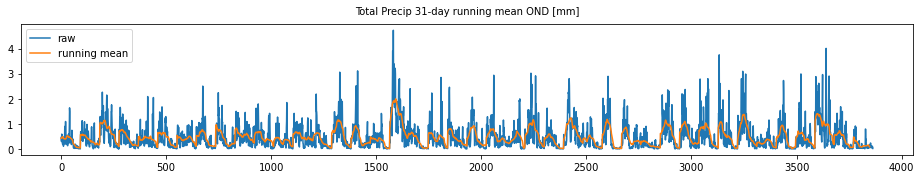

In [41]:
# East Africa
tp_dim=file.sel(longitude=slice(10,70),latitude=slice(24,-30))
tp_series=np.multiply(mask_nan,tp_dim).mean(dim='latitude',skipna=True).mean(dim='longitude',skipna=True)

# running mean
SYY = 1980   # start year, could be changed
EYY = 2021   # end year, could be changed
tp_sel = tp_series.sel(time=tp_series.time.dt.month.isin([10,11,12]))
tp_rol = tp_series.rolling(time=31, center=True).mean().sel(time=tp_series.time.dt.month.isin([10,11,12]))
tp_sel = tp_sel.sel(time = slice(str(SYY),str(EYY)))
tp_rol_sel = tp_rol.sel(time = slice(str(SYY),str(EYY)))

fig, axs = plt.subplots(1, figsize=plt.figaspect(0.15))
plt.plot(tp_sel.tp*1000, label='raw')
plt.plot(tp_rol_sel.tp*1000, label='running mean')
title = 'Total Precip 31-day running mean OND [mm]'
plt.title(title,fontsize=10, y=1.03)
# show the legend
plt.legend()
# show the plot
plt.show()

### Predictors

In [45]:
# choose physical variables you are interested in to see its spatial structure and EOF patterns and PC time series
# can select the values and region you want by changing the parameters

#file_vars = ['ERA5_t2m', 'era5_t_850hpa', 'era5_z_200hpa', 'era5_z_500hpa', 'sst', 'era5_olr']
file_vars = ['sst']
#header_vars = ['t2m', 't', 'z', 'z', 'sst', 'olr-mean']
header_vars = ['sst']

# select regions for the individual predictor
#lon_slices = [[-16,54],[-30,90],[-30,90],[-30,90],[-180,180],[40,180]]
#lat_slices = [[16,0],[30,-20],[-20,30],[-20,30],[40,-20],[-20,20]]
lon_slices = [[-180,178]]
lat_slices = [[40,-20]]

for file_var, header_var, lon_slice, lat_slice in zip (file_vars, header_vars, lon_slices, lat_slices):
    if file_var=='era5_olr':
        file = xr.open_mfdataset(root_data+file_var+'_1950_2021_daily_1deg_tropics.nc',
                                 combine='by_coords',parallel=True)
        print('olr')
        var_dim = file.sel(lon=slice(lon_slice[0],lon_slice[1]),lat=slice(lat_slice[0],lat_slice[1]))
        lon = var_dim.coords['lon'].values
        lat = var_dim.coords['lat'].values
    else:
        file = xr.open_mfdataset(root_data+file_var+'_1959-2021_1_12_daily_2.0deg.nc',
                                 combine='by_coords',parallel=True)
        print(header_var)
        var_dim = file.sel(longitude=slice(lon_slice[0],lon_slice[1]),latitude=slice(lat_slice[0],lat_slice[1]))
        lon = var_dim.coords['longitude'].values
        lat = var_dim.coords['latitude'].values

    nlon = len(lon)
    nlat = len(lat)
    
    var_series = var_dim.sel(time=var_dim.time.dt.year.isin([np.arange(SYY,EYY+1)])).rolling(time=7, center=False).mean(skipna=True)
    #print(var_series)
    
    var_anom_series = var_series.groupby("time.dayofyear") - var_series.groupby("time.dayofyear").mean("time",skipna=True)
    
    # Apply EOF -- use the months you want (base on how long the time series used as predictors)
    var_anom_sel = var_anom_series.sel(time=var_anom_series.time.dt.month.isin([7,8,9,10,11]))[header_var].values
    # first, make a grid out of the longitude and latitude vectors so they have the same dimensions 
    lon2d,lat2d = np.meshgrid(lon,lat)
    wgts = np.cos(lat2d/180*np.pi)**0.5
    print(wgts.shape)
    solver = Eof(var_anom_sel,weights=wgts)
    
    # EOFs are multiplied by the square-root of their eigenvalues (then the EOF patterns will carry the units)
    nmode = 5
    EOF = solver.eofs(neofs=nmode,eofscaling=2) # get the first four eofs
    print('EOF shape',np.shape(EOF))
    eigenv = solver.eigenvalues(neigs=nmode)
    #print('eigenvalues',eigenv)
    VarEx = solver.varianceFraction(neigs=nmode)*100
    print('the first '+str(nmode)+' modes explain '+str(np.round(sum(VarEx),2))+'% of the total variance of '+header_var)
    PC = solver.pcs(npcs=nmode,pcscaling=1)
    print('PC shape',np.shape(PC))

sst


/net/cfc/s2s/s2s_ai_challenge/conda/envs/s2sai_2020/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]


(31, 180)
EOF shape (5, 31, 180)
the first 5 modes explain 46.99% of the total variance of sst
PC shape (6426, 5)


/net/cfc/s2s/s2s_ai_challenge/conda/envs/s2sai_2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/net/cfc/s2s/s2s_ai_challenge/conda/envs/s2sai_2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


Text(0.5, 1.03, 'sst daily anomaly from 1980 to 2021')

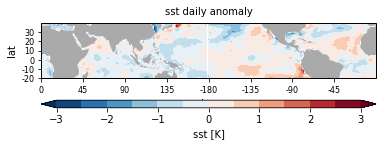

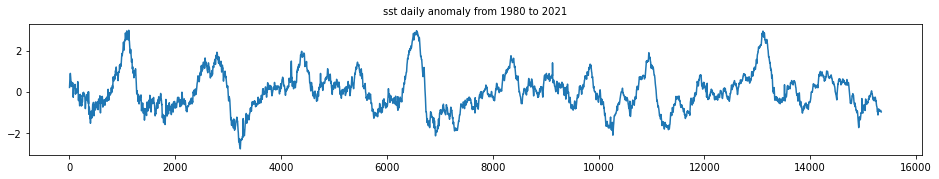

In [56]:
# plot the original data 
color = 'RdBu_r' 
colorbarMin = -3
colorbarMax = 3
colorspace = 0.5
level = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)
ax = plt.axes(projection=ccrs.cartopy.crs.PlateCarree(central_longitude=180))
h = ax.contourf(lon, lat, var_anom_series[header_var][122,:,:], level, transform=ccrs.PlateCarree(), cmap=color,extend='both')
cbar = plt.colorbar(h, orientation='horizontal', shrink=1,fraction=0.1,pad=0.1,aspect=40)
cbar.ax.tick_params(labelsize=10) 
colorLabel=header_var+' [K]'
cbar.set_label(label=colorLabel,fontsize=10)
#Add in the coordinate system:
long = np.arange(-180, 180, 45)#spacing of 45 degrees
latg = np.arange(-20, 40, 10)#spacing of 15 degrees
ax.set_xticks(long, crs=ccrs.PlateCarree());
ax.set_yticks(latg, crs=ccrs.PlateCarree());
ax.set_xticklabels(long,fontsize=8)
ax.set_yticklabels(latg,fontsize=8)
ax.set_ylabel('lat',fontsize=10);
ax.set_xlabel('lon',fontsize=10);

#Add in the continents
#define the coastlines, the color (#000000) and the resolution (110m) 
feature1 = cf.NaturalEarthFeature(
    name='coastline', category='physical',
    scale='110m',
    edgecolor='#000000', facecolor='none')
#define the land, the color (#AAAAAA) and the resolution (110m), mask the land, use for SST
feature2 = cf.NaturalEarthFeature(
    name='land', category='physical',
    scale='110m',
    facecolor='#AAAAAA')

ax.add_feature(feature2)

#Set a title for your map:
title = header_var+' daily anomaly'
plt.title(title,fontsize=10, y=1.03)

fig, axs = plt.subplots(1, figsize=plt.figaspect(0.15))
tmp = var_anom_series.sel(longitude=slice(-170,-120),latitude=slice(5,-5)) # for SST is Niño 3.4 index
dat = tmp.mean(dim='latitude',skipna=True).mean(dim='longitude',skipna=True)
dat = dat.sel(time = slice(str(SYY),str(EYY)))
plt.plot(dat[header_var])
title = header_var+' daily anomaly from '+str(SYY)+' to '+str(EYY)
plt.title(title,fontsize=10, y=1.03)

/net/cfc/s2s/s2s_ai_challenge/conda/envs/s2sai_2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/net/cfc/s2s/s2s_ai_challenge/conda/envs/s2sai_2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


Text(0.5, 1.03, 'sst JASON PC1')

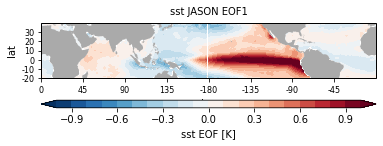

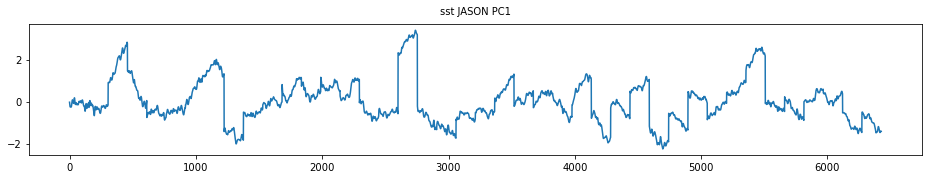

In [51]:
# plot EOF modes
import cartopy.crs as ccrs
import cartopy.feature as cf
ii = 0
color = 'RdBu_r' 
colorbarMin = -1
colorbarMax = 1
colorspace = 0.1
level = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)
ax = plt.axes(projection=ccrs.cartopy.crs.PlateCarree(central_longitude=180))
h = ax.contourf(lon, lat, EOF[ii,:,:], level, transform=ccrs.PlateCarree(), cmap=color,extend='both')
cbar = plt.colorbar(h, orientation='horizontal', shrink=1,fraction=0.1,pad=0.1,aspect=40)
cbar.ax.tick_params(labelsize=10) 
colorLabel=header_var+' EOF [K]'
cbar.set_label(label=colorLabel,fontsize=10)
#Add in the coordinate system:
long = np.arange(-180, 180, 45)#spacing of 45 degrees
latg = np.arange(-20, 40, 10)#spacing of 15 degrees
ax.set_xticks(long, crs=ccrs.PlateCarree());
ax.set_yticks(latg, crs=ccrs.PlateCarree());
ax.set_xticklabels(long,fontsize=8)
ax.set_yticklabels(latg,fontsize=8)
ax.set_ylabel('lat',fontsize=10);
ax.set_xlabel('lon',fontsize=10);

#Add in the continents
#define the coastlines, the color (#000000) and the resolution (110m) 
feature1 = cf.NaturalEarthFeature(
    name='coastline', category='physical',
    scale='110m',
    edgecolor='#000000', facecolor='none')
#define the land, the color (#AAAAAA) and the resolution (110m), mask the land, use for SST
feature2 = cf.NaturalEarthFeature(
    name='land', category='physical',
    scale='110m',
    facecolor='#AAAAAA')

ax.add_feature(feature2)

#Set a title for your map:
title = header_var+' JASON EOF'+str(ii+1)
plt.title(title,fontsize=10, y=1.03)

fig, axs = plt.subplots(1, figsize=plt.figaspect(0.15))
plt.plot(PC[:,ii])
title = header_var+' JASON PC'+str(ii+1)
plt.title(title,fontsize=10, y=1.03)